In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display


# 鑑黃大師 (tensorflow)

支援python 版本: 3.5以上
支援tensorflow版本 : 2.1以上

In [2]:
import os
os.environ['TRIDENT_BACKEND'] = 'tensorflow'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import efficientnet

trident 0.7.1


Using TensorFlow backend.
Image Data Format: channels_last.
Image Channel Order: rgb.
1 Physical GPUs, 1 Logical GPUs


Opencv version:4.1.2.


Tensorflow version:2.4.0.
use device:/gpu:0.
executing_eagerly


Pillow version:7.1.2.


網路上信息流通如此方便，也因此包括不宜兒童觀賞的成人信息也都能被輕易取得，在台灣沒有那麼嚴格的信息審查制度，在彼岸，還有一種稱為鑑黃師的職業，每天負責看網路上的各種情色信息並且標註標籤。不要以為這是一份天堂般快樂的職業，如果你得一天八小時不停的看，恐怕都要看出內傷了。這麼不人道的行業我們還是交給人工智能來處理，我們今天的實作就是要來做出能夠鑑別色情內容的鑑黃模型。

![Alt text](../images/porndetector.jpg)

這次我們使用的數據集是基於幾個來源，原本使用的是nsfw_data_scrapper公開數據集，他裡面共計有dawings(非色情繪畫)、hentai(變態的二次元漫畫)、neutral(正常一般圖片)、porn(色情圖片)以及sexy(性感圖片)這五種，也就是這是一個五分類的預測模型。它裡面提供了圖片連結需要事先下載。不過最大的問題在於，它的圖片數量非常龐大，原始來源有22萬張，但是很多連結已經失效，但更嚴重的是，這個資料來源有非常嚴重的偏差，因為它是設定幾組關鍵字去網站上爬圖，因此會有很多圖片與分類不合的問題，以及評估色情的尺度不一問題，也因此我是基於他的分類標準與圖片重新做了分類，同時色情的圖片我全部使利用爬蟲技術去PornHub抓取預覽圖，而drawings則是加入了大量WikiArt中的繪畫圖片(因為原作者的drawings裡面只有漫畫，沒有其他的繪畫類別)，至於sexy這個類別問題更嚴重，因為原作者的性感全是大胸泳裝美女，所以我加入了其他頒獎典禮紅毯、街頭時尚等圖片進去。這樣構成了這次實作訓練集與測試集。

如果各位原作者的圖資(僅供學術使用)，各位可以直接到以下位置取得數據集 https://github.com/alexkimxyz/nsfw_data_scrapper

![Alt text](../images/pornclass.jpg)

In [3]:
data_provider=load_examples_data('nsfw')
data_provider.image_transform_funcs=[
    #隨機調整圖片明暗gamma 0.6~1.5之間
    RandomAdjustGamma(gamma_range=(0.6,1.5)),
    #隨機調整圖片對比度
    RandomAdjustContrast(value_range=(0.6, 1.5)),
    #隨機調整色相
    RandomAdjustHue(value_range=(-0.5, 0.5)),
    #隨機加入噪音
    AddNoise(intensity=0.05),
    #隨機縮放裁切
    RandomRescaleCrop((224,224),scale_range=(0.7,2.0)),
    #隨機縮放平移旋轉
    RandomTransform(rotation_range= 15, zoom_range= 0.2, shift_range= 0.02,shear_range = 0.02,random_flip= 0.15),
    Normalize(0, 255),  
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]


print(data_provider.signature)

archive file is already existing, donnot need download again.
Starting to decompress the archive....
training images: 7305  test images:1845
Mapping class_names  in en-us   success, total 5 class names added.
Mapping class_names  in zh-cn   success, total 5 class names added.
Mapping class_names  in zh-tw   success, total 5 class names added.
data_provider( ) -> image: Tensor[(None, 224, 224, 3)] (ObjectType.rgb), label: Tensor[(None, 5)] (ObjectType.classification_label) 


In [4]:
#因為不能公開色情圖片，預覽圖片這個步驟就跳過
#data_provider.preview_images()

我們可以用label_statistics()函數來檢視類別的分布，可以看到是稍微不平衡的。

In [5]:
data_provider.label_statistics()

0          繪畫            ██████████                                         1,461 (20.000%)
1          色情漫畫      █████████                                          1,299 (17.782%)
2          中性            ████████████                                       1,689 (23.121%)
3          色情            ██████████████                                     1,998 (27.351%)
4          性感            ██████                                             858 (11.745%)


要是各位還覺得這個分類實在太粗糙，希望能有更詳細、規模更大的數據集(基於學術研究以及打擊網路色情的熱情?)，既然本次實作是升級版，當然有要提供更進階的圖資資訊囉，這個數據集總量高達158萬張圖，而且被細分至159個子類(如下圖)，圖資的位置就在:

https://github.com/EBazarov/nsfw_data_source_urls


![Alt text](../images/nsfw_data.jpg)

這次實作我們將使用的骨幹網路是谷歌於2019年3月所提出的EfficientNet，這個EfficientNet特別之處在於過去我們在調整神經網路結構時常使用的超參數包括了更寬(通道數)、更深(層數)以及更清晰(圖片解析度)，過去通常是這三個超參數獨立調整，而EfficientNet則是透過神經網路結構搜索(NAS)，找到了這三個超參數均勻連動的規律，讓模型結構可以同時兼顧3個超參數均勻的變動，由於這是透過神經網路結構搜索找出的最佳結構，因此EfficientNet-B7在 imagenet 上的TOP1準確率達到了史上最佳成績84.4%，在純CPU環境下模型大小只有谷歌之前提出的Gpipe的8.4分之1，但是執行速度卻快6.1倍。算是完美的達到了用較少參數來獲得更佳成績。

若要閱讀詳細論文請參考：
https://arxiv.org/abs/1905.11946

我們在這個實作中，將使用EfficientNet家族中最輕量的EfficientNet-B0來作為骨幹網路。

![Alt text](../images/EfficientNet.jpg)

In [6]:
#獲取EfficientNet-B0預訓練模型
#將全連接層長度改為5
effb0=efficientnet.EfficientNetB0(include_top=True,
             pretrained=True,
             freeze_features=True,
             input_shape=(224,224,3),
             classes=5)


effb0.summary()


model file is already existing, donnot need download again.
5288548 parameters have set untrainable
1281000 parameters have set trainable
--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                          Output Shape               Weight           Bias    Param #            FLOPS #         
stem.conv  Conv2d                                 [1, 112, 112, 32]        [3, 3, 3, 32]               864     21,663,488.0             
stem.norm  BatchNorm                              [1, 112, 112, 32]        [32]                [32]    64      1,191,680.0              
stem  Conv2d_Block                                [1, 112, 112, 32]                                    0       0.0                      
block1a.0.conv  DepthwiseConv2d                   [1, 112, 112, 32]        [3, 3, 32, 1]               288     7,212,800.0              
block1a.0.norm  BatchNorm               

ImageClassificationModel(
  (inputs): TensorSpec(shape=(None, 224, 224, 3), ndim=4, name=input)
  (_outputs): { output_0: TensorSpec(object_type=ObjectType.classification_label, name=output_0), output_1: TensorSpec(shape=(None, 5), name=output_1) }
  (_targets): TensorSpec(object_type=ObjectType.classification_label, name=output_0)
  (_targets): TensorSpec(shape=(None, 5), name=output_1)
)

In [7]:
#只開放全連接層以及最後一組Efficient Block開放學習

effb0.model.fc.trainable=True
effb0.model.block7a.trainable=True
print(effb0.signature)

no parameter trainable state is changed
717232 parameters have set trainable
efficientnet-b0( input: Tensor[(None, 224, 224, 3)] ) -> output_0: Tensor[None] (ObjectType.classification_label), output_1: Tensor[(None, 5)]  


由於這次時做模型的重點在於要能正確的區辨色情圖片，為了避免最後的模型可能發生整體準確率高但是色情圖片的識別能力卻很弱，我們在模型評估指標準多加入了召回率(recall，在所有色情圖片中，實際上被正確預測的比例)，這跟正確率(在所有預測是色情圖片的案例中，實際上被正確預測的比例)差別在於分布不同，正確率是避免錯殺，而召回率是避免錯放。

In [8]:
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_epoch_start(self, training_context):
        if training_context['current_epoch']==3:
            training_context['current_model'].block6d.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==5:
            training_context['current_model'].block6c.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']>=10 and training_context['current_epoch']%5==0:
            training_context['optimizer'].lr=training_context['optimizer'].lr*0.5
            #每訓練5 epoch，學習速率降一半
            

        

接下來則是設定模型訓練的相關訊息。其中，優化器部分還是使用強力推薦的Ranger(比Adam還要強大)，學習速率我的初始值為2e-3，原因在於把學習速率調大，整個模型收斂速度會非常快。

In [9]:

effb0.with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss(auto_balance=True))\
    .with_loss(F1ScoreLoss(auto_balance=True,beta=0.5))\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(accuracy,ignore_index=[0,2,3,4],name='accuracy_hentai')\
    .with_metric(accuracy,ignore_index=[0,1,2,4],name='accuracy_porn')\
    .with_metric(recall,ignore_index=[0,1,2,4],name='recall_porn')\
    .with_regularizer('l2',reg_weight=1e-6)\
    .with_model_save_path('Models/porn_detection_tf.pth')\
    .with_callbacks(CustomCallback())\
    .with_automatic_mixed_precision_training()

#指定優化器(使用Ranger)
#設定損失函數(交叉熵)
#設定評估函數(正確率與召回率)
#設定l2正則化
#設定min_max_norm權重約束
#指定模型存檔位置
#指定學習速率調整機制

accuracy( output, target) -> accuracy 
accuracy_hentai( output, target) -> accuracy_hentai 
accuracy_porn( output, target) -> accuracy_porn 
recall_porn( output, target) -> recall_porn 


automatic mixed precision training only enable when using pytorch 1.6 (or higher) as backend and cuda is available.

ImageClassificationModel(
  (inputs): TensorSpec(shape=(None, 224, 224, 3), ndim=4, name=input)
  (_outputs): { output_0: TensorSpec(object_type=ObjectType.classification_label, name=output_0), output_1: TensorSpec(shape=(None, 5), name=output_1) }
  (_targets): TensorSpec(object_type=ObjectType.classification_label, name=output_0)
  (_targets): TensorSpec(shape=(None, 5), name=output_1)
  (_losses): <trident.optims.tensorflow_losses.CrossEntropyLoss object at 0x0000026FDDA06710>
  (_losses): <trident.optims.tensorflow_losses.F1ScoreLoss object at 0x0000026FDDA06F60>
  (_metrics): functools.partial(<function accuracy at 0x0000026FD73DCA60>)
  (_metrics): functools.partial(<function accuracy at 0x0000026FD73DCA60>, ignore_index=[0, 2, 3, 4])
  (_metrics): functools.partial(<function accuracy at 0x0000026FD73DCA60>, ignore_index=[0, 1, 2, 4])
  (_metrics): <function recall at 0x0000026FD73DCAE8>
  (loss_weights): 1.0
  (loss_weights): 1.0
  (_regs): functools.partial(<function l2_reg at 

In [10]:
#設定學習計畫
#指定資料提供者
#跑20個epoach
#minibatch_size為32
#每20個批次列印一次訓練進度
#每100個批次使用測試集測試一次
#每200個批次顯示一次loss_metric_curve
#每100個批次存檔一次
plan=TrainingPlan()\
    .add_training_item(effb0)\
    .with_data_loader(data_provider)\
    .repeat_epochs(20)\
    .with_batch_size(32)\
    .print_progress_scheduling(20,unit='batch')\
    .out_sample_evaluation_scheduling(100,'batch')\
    .display_loss_metric_curve_scheduling(frequency=200,unit='batch',imshow=True)\
    .save_model_scheduling(100,unit='batch')\
    

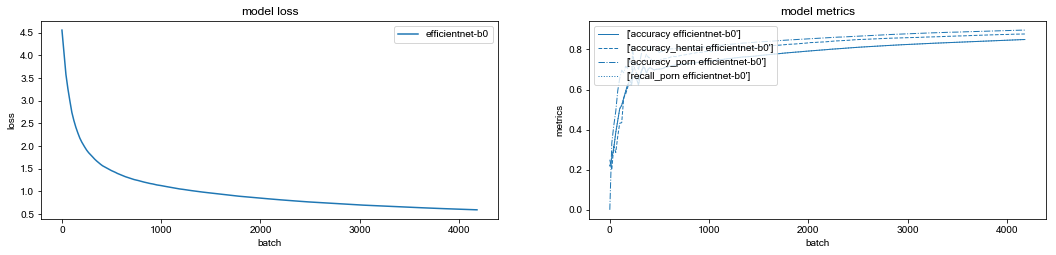

efficientnet-b0  Step: 10s780ms | Loss: 0.604 | accuracy: 84.686% ,accuracy_hentai: 87.545% ,accuracy_porn: 89.478% ,recall_porn: 84.686%  | learning rate: 2.500e-04  | epoch: 18  ( 80/229 )
efficientnet-b0  Step: 11s659ms | Loss: 0.603 | accuracy: 84.721% ,accuracy_hentai: 87.569% ,accuracy_porn: 89.503% ,recall_porn: 84.721%  | learning rate: 2.500e-04  | epoch: 18  ( 100/229 )
efficientnet-b0: out-of-sample evaluation:  accuracy: 71.875% ,accuracy_hentai: 66.667% ,accuracy_porn: 84.615% ,recall_porn: 71.875% 
efficientnet-b0  Step: 10s932ms | Loss: 0.601 | accuracy: 84.756% ,accuracy_hentai: 87.593% ,accuracy_porn: 89.528% ,recall_porn: 84.756%  | learning rate: 2.500e-04  | epoch: 18  ( 120/229 )
efficientnet-b0  Step: 10s575ms | Loss: 0.600 | accuracy: 84.791% ,accuracy_hentai: 87.616% ,accuracy_porn: 89.552% ,recall_porn: 84.791%  | learning rate: 2.500e-04  | epoch: 18  ( 140/229 )
efficientnet-b0  Step: 10s421ms | Loss: 0.598 | accuracy: 84.827% ,accuracy_hentai: 87.641% ,accur

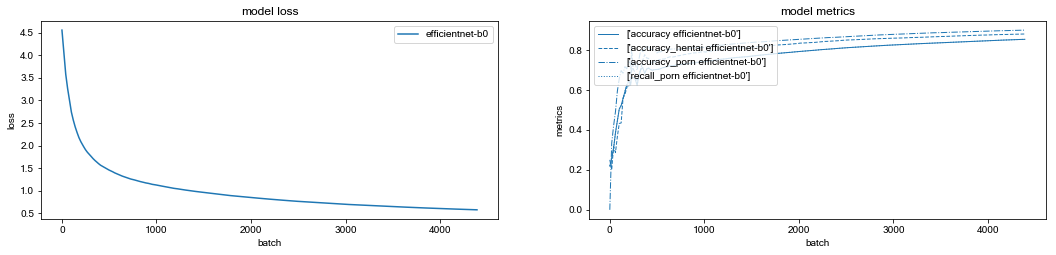

efficientnet-b0  Step: 12s65ms  | Loss: 0.589 | accuracy: 85.065% ,accuracy_hentai: 87.806% ,accuracy_porn: 89.746% ,recall_porn: 85.065%  | learning rate: 2.500e-04  | epoch: 19  ( 60/229 )
efficientnet-b0  Step: 10s493ms | Loss: 0.587 | accuracy: 85.096% ,accuracy_hentai: 87.825% ,accuracy_porn: 89.769% ,recall_porn: 85.096%  | learning rate: 2.500e-04  | epoch: 19  ( 80/229 )
efficientnet-b0  Step: 10s101ms | Loss: 0.586 | accuracy: 85.126% ,accuracy_hentai: 87.845% ,accuracy_porn: 89.793% ,recall_porn: 85.126%  | learning rate: 2.500e-04  | epoch: 19  ( 100/229 )
efficientnet-b0: out-of-sample evaluation:  accuracy: 65.625% ,accuracy_hentai: 100.000%,accuracy_porn: 92.308% ,recall_porn: 65.625% 
efficientnet-b0  Step: 9s870ms  | Loss: 0.585 | accuracy: 85.156% ,accuracy_hentai: 87.865% ,accuracy_porn: 89.817% ,recall_porn: 85.156%  | learning rate: 2.500e-04  | epoch: 19  ( 120/229 )
efficientnet-b0  Step: 9s851ms  | Loss: 0.583 | accuracy: 85.186% ,accuracy_hentai: 87.886% ,accura

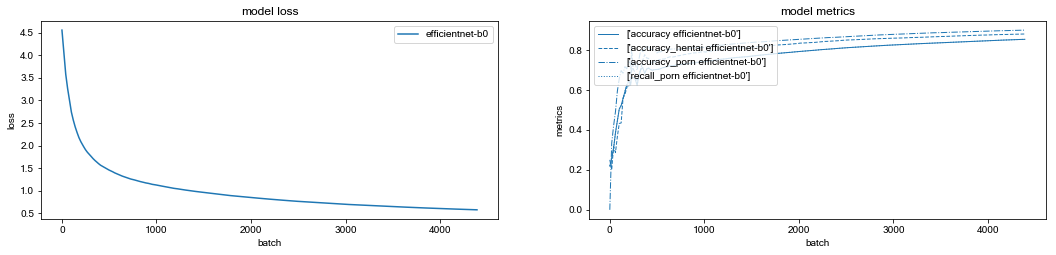

In [11]:
#執行訓練
plan.start_now()

從訓練的過程可以看到，隨著正確率緩步提升，模型對於色情圖片的召回率卻衝的很快，訓練初期整體準確率偏低，因此可以推斷那時的模型優先學習了如何判斷色情圖片(由於我們沒有把召回率作為損失函數，因為它不可微分，因此推斷色情這個類別數量最多，機器就直接先把所有圖片都假設為色情，因此召回率一下衝高。)，由於我們還額外加入了F1ScoreLoss，其中的beta=0.5表示精確度要比召回率更重要，而且我們兩個損失函數都設置了auto_balance(自動類平衡)，它會讓數量不均勻的樣本最終會獲得接近精確度或召回率，而不會變成偏向數量大的類別的問題。

所以當召回率達到高點後，機器也開始學習其他標籤的特徵，但是隨著模型的訓練，整體準確率提升，召回率呈現略有降低，但是仍保持在9成以上的水準。

就和之前的圖像識別實作類似，在trident中，我們的模型是實做了ImageClassificationModel子類，只要將類別代碼表class_names，以及圖片數據預處理流程preprocess_flow設定好，就可以很方便的直接利用infer_single_image來進行單張圖片推論。由於我們是使用預訓練模型來做微調，因此原本模型對應的是imagenet 1000個類別的代碼表，所以我們需要將它修改為5類別的代碼表，這可以直接從data provider這邊複製過來。

In [13]:

effb0.eval()
effb0.class_names=['繪畫','色情漫畫','中性','色情','性感']

effb0.preprocess_flow=[
    Resize((224,224),True),
    Normalize(0, 255),  
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

{ 繪畫: (0, 0.76025146), 色情漫畫: (1, 0.2392129), 性感: (4, 0.0002772323) }


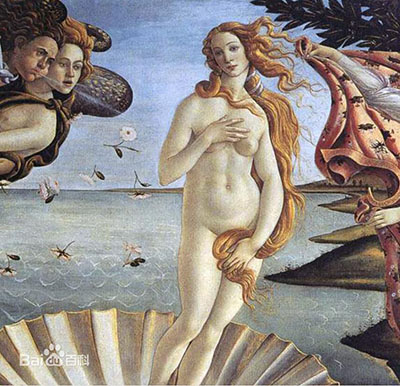

In [14]:
print(effb0.infer_single_image('../images/venus.jpg',3))
display.Image('../images/venus.jpg')

可能學習了太多色情圖片，瑪丹娜當年被禁的MV \[Jutisfy My Love\]在機器看來也只是中性而已。

{ 中性: (2, 0.9032341), 色情: (3, 0.051376753), 性感: (4, 0.03971451) }


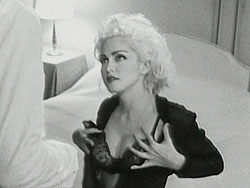

In [15]:
print(effb0.infer_single_image('../images/JutisfyMyLove.jpg',3))
display.Image('../images/JutisfyMyLove.jpg')

{ 性感: (4, 0.8479404), 色情漫畫: (1, 0.084156275), 繪畫: (0, 0.05765348) }


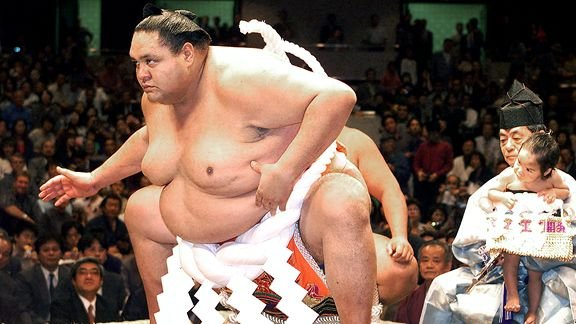

In [16]:

print(effb0.infer_single_image('../images/sumo.jpg',3))
display.Image('../images/sumo.jpg')

{ 性感: (4, 0.96523297), 中性: (2, 0.034182765), 繪畫: (0, 0.0005369756) }


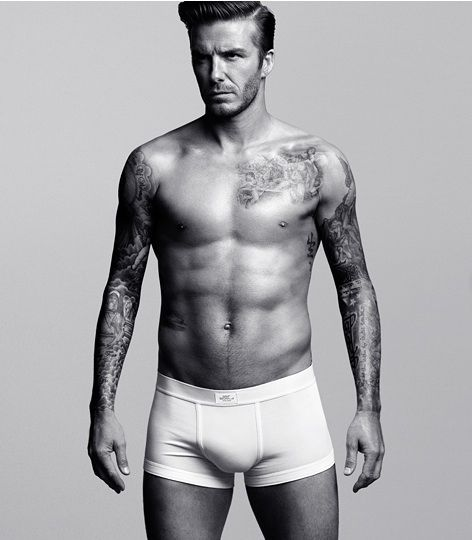

In [17]:
print(effb0.infer_single_image('../images/beckham.jpg',3))
display.Image('../images/beckham.jpg')

{ 色情漫畫: (1, 0.9911644), 性感: (4, 0.0078868065), 繪畫: (0, 0.000913406) }


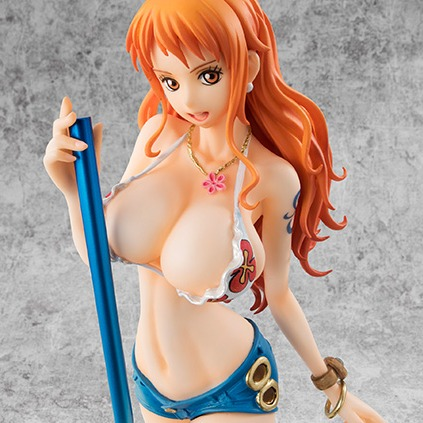

In [18]:
print(effb0.infer_single_image('../images/nami.jpg',3))
display.Image('../images/nami.jpg')

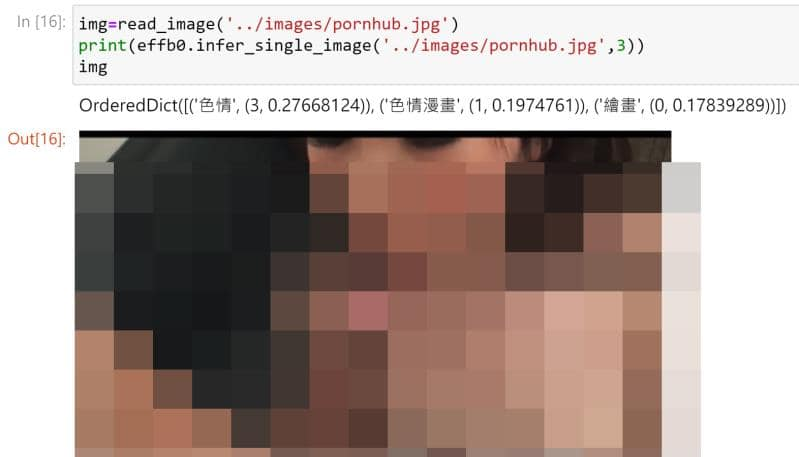

In [19]:
display.Image('../images/pornhub.jpg')
